# Summary of Findings


### Introduction
    This project explores the NYPD allegations dataset. The NYPD allegations dataset contains 12,000 civillian complaints filed against New York City police officers. Our principal question of interest is a classification problem: How can we predict the gender of the complainant given the other features within the dataset? After exploring the data and seeing multiple classifications of gender, we ultimately decided to focus our gender prediction on binary gender, males and females. For our target variable, we used complainant gender consisting of males and females. For our evaluation metric, we figured we would use the accuracy score of our model to see what proportion of predictions the model got correct compared to the actual outcomes in our NYPD allegations dataset. We used this metric to evaluate how successful the features we used were in predicting the outcomes of complainant gender.

### Baseline Model
    We performed some modifications to the original dataset. Primarily we cleaned the dataset so the values were valid for our model. However, we did perform one specific modification where we replaced the months and years recieved and closed with a complaint_length column where its the total number of days between the date where the complaint started and ended. For our model, we used 8 features from the dataset. We used 3 quantitiative features: 'mos_age_incident', 'complainant_age_incident', and 'complaint_length'. Our model used 5 nominal features:'allegation', 'outcome_description', 'mos_ethnicity', 'mos_gender', and 'complainant_ethnicity'. Our model did not use any ordinal features. Our baseline model used a decision tree classifier and we split the data into 70:30 proportions for training and test sets respectively. We used accuracy as our evaluation metric and from fitting on the training set, we got a test accuracy of 0.813845966662611 from the baseline model. This accuracy seems good especially since we did not apply any improvements on the model (ex. hyperparameter tuning or transformations).     

### Final Model
    Our improved model uses some modifications to the original. Added three new features to the model. We deicded to standard scale the mos_age_incident, complainant_age_incident, and the complaint_length. For example, the average age of complainants and mos are both 32, but complainants have cases where their age really small, such as 0 or 1. As such these values may skew our predictions. In the same logic, complainant length has many outliers on both sides of the distribution, so through standardizing, we believe our model may perform better. In addition to these new engineered features, we also decided to go with a random forest classifier instead of our decision tree classifer. While decision trees are easier to intepret and train, at times they can weigh certain sets of features more than others. However, random forests select the features randomly during training which means that random forests do not depend as signficantly on a specific set of features the same way deicsion trees do. As such, we believe using a random forest classifier would lead to better predictions than our original baseline model. Lastly, we performed gridsearch cross validation (5 folds) on the following parameters of random forest classifier: max_depth, min_samples_split, and min_samples_leaf. We found None, 3, and 10 for max_depth, min_samples_split, and min_samples_leaf respecitvely to be the optimal parameters from grid search cross validation. Our final model achieved a test accuracy of 0.8295413067283125. This is approximately a 2% improvement from the baseline model. Interestly enough, we also fitted an intermediate model where we added the new features and changed to random forest classifier and performed much better than using the optimal parameters from grid search cross validation. This intermediate pipeline got a test accuracy of 0.8431682686458206. More than a 1% improvement from the final model and a 3% improvement from the baseline model. We are not sure why this happended but are rather perplexed. 

### Fairness Evaluation
    In the last part of our solution, we evaluated the fairness of our final model. In order to do so, we had to pick an interesting feature from our dataset. After looking at all the different possibilities, we decided to use the feature complainant_age_incident. Before we conducted the permutation test, we looked at the predictions of our classification model on the test set. With these predictions and the actual outcomes in the test set, we created a confusion matrix, that allowed us to see the percentage of true positives, true negatives, false positives, and false negatives. We confirmed our accuracy score of 0.83233970 by adding the true positive and true negative scores. Afterwards, with complainant age as our interesting subset, we wanted to explore whether our final model is fairer for younger or older people. We binarized this subset by putting an age threshold at 30, deeming everyone younger than 30 as 'young' and everyone older as 'old'.
    
    Now that our dataset is split into subsets, we used the accuracy parity and found scores of 0.795178 for old people and 0.862488 for young people. This meant that our final model could correctly predict around roughly 6 percent more young people compared to old people. Finally, we conducted our permutation test for gender across young and old age groups. Our null hypothesis is that our model is fair; the accuracy for our two subsets are the same. Our alternative hypothesis is that our model is unfair; the accuracy for the old subset is higher than the young subset. We first calculated an accuracy observed test statistic of 0.06731035582578437. Then, we used our binarized data of complainant age, predictions, and the actual outcomes to conduct the permutation test using the differences and with N as 1000. We discovered that our observed test statistic is greater than 100% of the differences resulted in our permutation test. Thus, our p-value is 0, and we reject the null hypothesis. Ultimately, we do not have convincing evidence to conclude that our model is fair, and that our accuracy for our two subsets are roughly the same.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
# Importing sklearn functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.base import BaseEstimator, TransformerMixin

### Reading in the data

In [3]:
# Reading in the Dataset
data_fp = os.path.join('data','allegations.csv')
data = pd.read_csv(data_fp)

In [4]:
# Portion of the data
data.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


In [5]:
# Datatypes for each column
data.dtypes

unique_mos_id                 int64
first_name                   object
last_name                    object
command_now                  object
shield_no                     int64
complaint_id                  int64
month_received                int64
year_received                 int64
month_closed                  int64
year_closed                   int64
command_at_incident          object
rank_abbrev_incident         object
rank_abbrev_now              object
rank_now                     object
rank_incident                object
mos_ethnicity                object
mos_gender                   object
mos_age_incident              int64
complainant_ethnicity        object
complainant_gender           object
complainant_age_incident    float64
fado_type                    object
allegation                   object
precinct                    float64
contact_reason               object
outcome_description          object
board_disposition            object
dtype: object

### Data Cleaning and Feature Selection

In [6]:
# Data cleaning and deciding which features to use

## Creates a date column of month and year (received and closed) in the format "Month - Year" then converts string column to datetime
data["date_received"] = data.month_received.astype(str) + "-" + data.year_received.astype(str)
data["date_received"] = pd.to_datetime(data['date_received'])

data["date_closed"] = data.month_closed.astype(str) + "-" + data.year_closed.astype(str)
data["date_closed"] = pd.to_datetime(data['date_closed'])

## Creates a column that computes the total time the case was open (in days)
data['complaint_length'] = (data.date_closed - data.date_received).dt.days 

## Cleans "Unknown values"
data.complainant_ethnicity = (data.complainant_ethnicity.replace("Unknown", np.NaN))

## Cleans Missing values from complainant age incident
data.complainant_age_incident = data.complainant_age_incident.replace(-1, np.NaN).replace(-4301, np.NaN)

## Only uses binary genders
data = data[data['complainant_gender'].isin(["Male", "Female"])]

## Encoding Male as 1, female as 0
data.complainant_gender = data.complainant_gender.replace({"Male":1, "Female":0})

# features used 
cols = ['allegation', 
    'outcome_description', 
    'mos_ethnicity', 
    'mos_gender', 
    'mos_age_incident', 
    'complainant_ethnicity', 
    'complainant_age_incident', 
    'complaint_length', 
    'complainant_gender']

## Portion of the dataset used
subdata = data[cols]

## Removes null values for models
for col in subdata.columns:
    subdata = subdata[subdata[col].isnull() == False]

In [7]:
# Portion of dataset used in model
subdata.head()

,allegation,outcome_description,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_age_incident,complaint_length,complainant_gender
0,Failure to provide RTKA card,No arrest made or summons issued,Hispanic,M,32,Black,38.0,305,0
1,Action,Moving violation summons issued,White,M,24,Black,26.0,274,1
2,Race,Moving violation summons issued,White,M,24,Black,26.0,274,1
3,Question,No arrest made or summons issued,White,M,25,Black,45.0,427,1
5,Refusal to process civilian complaint,No arrest made or summons issued,Black,F,50,White,31.0,153,1


In [8]:
subdata

,allegation,outcome_description,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_age_incident,complaint_length,complainant_gender
0,Failure to provide RTKA card,No arrest made or summons issued,Hispanic,M,32,Black,38.0,305,0
1,Action,Moving violation summons issued,White,M,24,Black,26.0,274,1
2,Race,Moving violation summons issued,White,M,24,Black,26.0,274,1
3,Question,No arrest made or summons issued,White,M,25,Black,45.0,427,1
5,Refusal to process civilian complaint,No arrest made or summons issued,Black,F,50,White,31.0,153,1
...,...,...,...,...,...,...,...,...,...
33353,Word,Moving violation summons issued,White,M,36,Asian,21.0,184,1
33354,Interference with recording,Moving violation summons issued,White,M,36,Asian,21.0,184,1
33355,Search (of person),Moving violation summons issued,White,M,36,Asian,21.0,184,1
33356,Vehicle search,Moving violation summons issued,White,M,36,Asian,21.0,184,1


### Baseline Model

In [9]:
# Initalize X and y values
X = subdata.drop("complainant_gender", axis = 1)
y = subdata.complainant_gender

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.31)

In [16]:
X_train.head()

,allegation,outcome_description,mos_ethnicity,mos_gender,mos_age_incident,complainant_ethnicity,complainant_age_incident,complaint_length
14217,Frisk,Moving violation summons issued,White,M,25,Hispanic,41.0,151
4207,Forcible Removal to Hospital,No arrest made or summons issued,White,M,29,Asian,41.0,486
20869,Refusal to provide name/shield number,Summons - other violation/crime,White,M,28,Black,23.0,181
11652,Refusal to provide name/shield number,Arrest - other violation/crime,White,M,45,Black,50.0,153
23153,Interference with recording,Arrest - resisting arrest,Hispanic,M,30,Black,22.0,215


In [18]:
y_train

14217    1
4207     1
20869    0
11652    0
23153    1
        ..
20181    1
17776    1
5903     1
4520     1
33344    1
Name: complainant_gender, Length: 18903, dtype: int64

In [13]:
X.shape

(27396, 8)

In [12]:
X_train.shape

(18903, 8)

In [14]:
X_test.shape

(8493, 8)

In [9]:
# Creation of baseline model, 

# features to be one hot encoded
cat_feats = ["allegation",
             "outcome_description",
             "mos_ethnicity", 
             "mos_gender",
             "complainant_ethnicity",
            ]

# preprocessing step
preproc = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_feats)
    ])

# baseline model pipeline
pl = Pipeline(steps=[('preprocessor', preproc), ('dtreeclass', DecisionTreeClassifier())])

In [14]:
# Improving the model

# Parameter testing for decision tree classifier
params = {
    'dtreeclass__max_depth': [3,4,5],
    'dtreeclass__min_samples_split':[3,5,7,10,15]
}

# gridsearch cross validation with cross validation with 5 folds
clf = GridSearchCV(pl, params, cv = 6)

In [15]:
clf.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['allegation',
                                                                          'outcome_description',
                                                                          'mos_ethnicity',
                                                                          'mos_gender',
                                                                          'complainant_ethnicity'])])),
                                       ('dtreeclass',
                                        DecisionTreeClassifier())]),
             param_grid={'dtreeclass__max_depth': [3, 4, 5],
                         'dtreeclass__min_samples_split': [3, 5, 7, 10, 15]})

In [16]:
len(clf.cv_results_['mean_test_score'])

15

In [17]:
15*6

90

In [465]:
# baseline model fitting on training set
pl.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['allegation',
                                                   'outcome_description',
                                                   'mos_ethnicity',
                                                   'mos_gender',
                                                   'complainant_ethnicity'])])),
                ('dtreeclass', DecisionTreeClassifier())])

In [478]:
# test accuracy of baseline model
pl.score(X_test,y_test) 

0.813845966662611

### Final Model

In [469]:
# scaled features
num_feats = ["mos_age_incident",
             "complainant_age_incident",
             "complaint_length"
            ]

# preprocessing step
preproc2 = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_feats),
        ('num', StandardScaler(), num_feats)
    ])

# intermediate pipeline with random forest and engineered features (without gridsearchcv)
pl2 = Pipeline(steps=[('preprocessor', preproc2), ('rfclass', RandomForestClassifier())])

In [468]:
# intermediate model (no grid search cv)
pl2.fit(X_train,y_train)
pl2.score(X_test, y_test)

0.8431682686458206

In [470]:
# Improving the model

# Parameter testing for decision tree classifier
params = {
    'rfclass__max_depth': [3,4,5,6,9,10,12,15,16,18,None],
    'rfclass__min_samples_split':[3,5,7,10,15],
    'rfclass__min_samples_leaf':[3,5,7,10,15]
}

# gridsearch cross validation with cross validation with 5 folds
clf2 = GridSearchCV(pl2, params, cv = 5)

In [471]:
# fitting on training set (GRID SEARCH CV)
clf2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['allegation',
                                                                          'outcome_description',
                                                                          'mos_ethnicity',
                                                                          'mos_gender',
                                                                          'complainant_ethnicity']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['mos_age_incident',
  

In [472]:
# best parameters found from gridsearch cv
clf2.best_params_

{'rfclass__max_depth': None,
 'rfclass__min_samples_leaf': 3,
 'rfclass__min_samples_split': 10}

In [474]:
# final pipeline with best parameters found by GSCV
pl_final = Pipeline(
    steps=[('preprocessor',preproc2), 
           ('rfclass',RandomForestClassifier(max_depth=None,min_samples_leaf=3,min_samples_split=10))
          ])

In [475]:
pl_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['allegation',
                                                   'outcome_description',
                                                   'mos_ethnicity',
                                                   'mos_gender',
                                                   'complainant_ethnicity']),
                                                 ('num', StandardScaler(),
                                                  ['mos_age_incident',
                                                   'complainant_age_incident',
                                                   'complaint_length'])])),
                ('rfclass',
                 RandomForestClassifier(min_samples_leaf=3,
                                        min_samples_split=10))])

In [476]:
# test accuracy on final pipeline
pl_final.score(X_test, y_test)

0.8295413067283125

### Fairness Evaluation

In [483]:
# Predictions from improved model
preds = pl_final.predict(X_test)

In [484]:
# Creates a results dataframe 
results = X_test.copy()

# age_bracket divides the individuals by age brackets (bins of size 5 years)
results['age_bracket'] = results['complainant_age_incident'].apply(lambda x:5*(x//5 + 1))

# prediction gives the prediction results from earlier
results['prediction'] = preds

# outcome are the actual labels from y_test
results['outcome'] = y_test

In [485]:
# Confusion Matrix
metrics.confusion_matrix(y_test,preds) / len(preds)

array([[0.00876019, 0.16741696],
       [0.00304173, 0.82078112]])

In [486]:
# Creates a binary variable depending on if a complainant was younger or equal to 30
results['is_young'] = (results['complainant_age_incident'] <= 30).replace({True:'young', False:'old'})

In [487]:
#accuracy parity
(
    results
    .groupby('is_young')
    .apply(lambda x: metrics.accuracy_score(x.outcome, x.prediction))
    .rename('accuracy')
    .to_frame()
)

,accuracy
is_young,
old,0.795178
young,0.862488


In [488]:
# permutation testing

# observed statistic (accuracy)
obs = results.groupby('is_young').apply(lambda x: metrics.accuracy_score(x.outcome, x.prediction)).diff().iloc[-1]

metrs = []
for _ in range(1000):
    s = (
        results[['is_young', 'prediction', 'outcome']]
        .assign(is_young=results.is_young.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_young')
        .apply(lambda x: metrics.accuracy_score(x.outcome, x.prediction))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)

In [489]:
pd.Series(metrs <= obs).mean() # proportion of sample accuracies less than observed

1.0

In [490]:
obs # observed statistic

0.06731035582578437

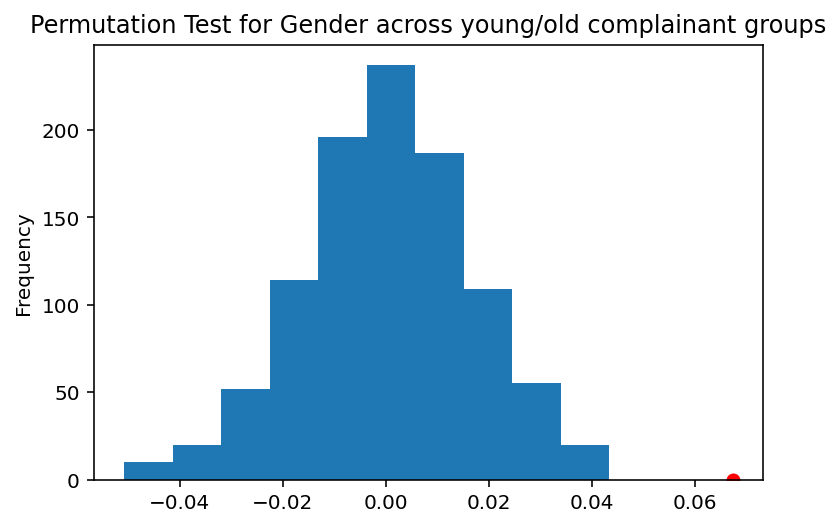

In [491]:
# histogram of empirical distribution with observed statistic
pd.Series(metrs).plot(kind='hist', title='Permutation Test for Gender across young/old complainant groups')
plt.scatter(obs, 0, c='r');